# 2 Data Preparation

**Team 1:** John Chen, Mendelina Lopez, and Katie Hu

The focus of this notebook is to prepare the data for modeling based on our initial exploratory data analysis.
  
<font color = red > **NOTICE:** </font> This study uses Twitter data to detect hate speech and offensive language. The content can be triggering due to the nature of the study with text consisting of racist, homophobic, sexist, and offensive language.
<br>
<br>  
***

#### Import Libraries and Establish Paths to Directory

In [2]:
# Libraries For Data Preparation
import os
import re
import sys
import pandas as pd
import numpy as np
import nltk
import contractions
import string
from collections import defaultdict, Counter
from string import punctuation
from nltk import pos_tag
from nltk.tokenize import RegexpTokenizer, word_tokenize, TweetTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tabulate import tabulate
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split

# For Graphs
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

# NLTK Downloads
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/katiehu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/katiehu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/katiehu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/katiehu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /Users/katiehu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/katiehu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
# Set Path to EDA Analysis Phase II
eda_path2 = '../Image/Exploratory Data Analysis/EDA Phase II/'

# Read in Data
data = pd.read_csv('../Data/Data_Source.csv', index_col = [0])
data.head()

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24783 entries, 0 to 25296
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   count               24783 non-null  int64 
 1   hate_speech         24783 non-null  int64 
 2   offensive_language  24783 non-null  int64 
 3   neither             24783 non-null  int64 
 4   class               24783 non-null  int64 
 5   tweet               24783 non-null  object
dtypes: int64(5), object(1)
memory usage: 1.3+ MB


In [5]:
df1 = data.copy()

In [6]:
# Shape Quality Check
print(' There are', df1.shape[0], 'and', df1.shape[1], 'columns in the dataframe.')

 There are 24783 and 6 columns in the dataframe.


#### Data Preparation

From the initial EDA, Twitter tweets came with a lot of mispelled words, variations of the root form of a word and repeated characters.
The following will be performed to ensure better accuracy of data by reducing the corpus to be more concentrated.

**Tokenization -**
Tokenization is the process of breaking a text into individual units called tokens. For regular tokenization a function called “word_tokenize” can be used from the “nltk” library. However, tweets have specific symbols such as “@” to callout a username and “#” to index keywords or topics, the tokenization needs to be handled differently. To address this, the “TweetTokenizer” function to keep both “#” (hashtags) and “@” (at) symbols in front of words preserving their significance for additional analysis.

**Remove Stopwords -**
The tweets had a significant amount of stopwords that impacted the overall word frequency and did not signify any importance to the sentiment as well as detecting hate speech and offensive language. Some of the stopwords removed were “and”, “the”, “it”, etc. Additional overused words that did not benefit the corpus such as “retweet” and “RT” were removed as well.

**Replace HTML Entity Codes -**
The corpus had HTML entity codes that were seen through a randomized sample pull of tweets to analyze the corrections where codes such as “&amp” and “&gt” were being corrected to “amp” and “gt” during the removal of punctuations leading to inaccurate words fed into the corpus as “&amp” stands for “&” and “&gt” is “>”. To counteract any HTML entity codes within the tweets, a function was added in to replace any HTML entity codes with the correct character prior to punctuation removal.

**Remove Punctuation -**
Tweets had a considerable amount of punctuation marks to emphasize a post where the most common punctuation would be a series of four to five exclamation points.

**Lemmatization -**
Lemmatization is a linguistic process used in NLP to reduce words to their base or root form also known as the lemma. This process helps reduce the dimensionality of the text data and brings together words with the same base. The effectiveness depends on if the word can be found in the lexicon, such as the WordNet library. Some examples of lemmatization using WordNet are estimated → estimate, is → be, and was → be. Words that cannot be found in the lexicon will remain the same such as “tryna” and “witchu”. Both words are slang and not found in any dictionary.

In [7]:
df1

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...
25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [8]:
# Create Functions For Cleaning Tweets

sw = stopwords.words("english")
lemmatizer = WordNetLemmatizer()  
# Create Function for Cleaning Tweet

def data_preparation_pipeline(tweet):
    tweet = str(tweet).lower() # Convert tweet to lowercase
    tweet = re.sub('\[.*?\]', '', tweet) # Remove text within square brackets
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet) # Remove URLs starting with "http://" or "https://"
    tweet = re.sub('https?://\S+|www\.\S+', '', tweet) # Remove URLs starting with "https://" or "www."
    tweet = tweet.replace('&gt;', '>') # Replaces html sign for greater than sign
    tweet = tweet.replace('&le;', '<') # Replaces html sign for less than sign
    tweet = tweet.replace('&equals;', 'equals') # Replaces html sign for equals
    tweet = tweet.replace('&amp;', 'and') # Replaces html sign for equals
    tweet = tweet.replace('&#8220;', '"') # Replaces html sign for quotation mark
    tweet = re.sub('<.*?>+', '', tweet) # Remove HTML tags
    punctuation_to_keep = ['#', '@'] # Keep Hashtag and @ symbols
    tweet = ''.join(char for char in tweet if char.isalnum() or char in punctuation_to_keep or char.isspace()) # Remove punctuation marks
    tweet = re.sub('\n', '', tweet) # Remove newlines
    tweet = re.sub(r'#\d+', '', tweet) # Remove hashtags followed by digits
    tweet = re.sub(r'[0-9]', '', tweet) # Remove digits
    tweet = re.sub(r'#', '', tweet) # Remove hashtags
    tweet = re.sub('\w*\d\w*', '', tweet) # Remove words containing numbers
    tweet = tweet.replace('rt', '')  # Remove "rt" from the tweet
    tweet = tweet.replace('RT', '')  # Remove "RT" from the tweet
    tweet = re.sub('VIDEO:','', tweet) # Remove Video label from the tweet
    tweet = re.sub(r"\s+",' ', tweet) # Remove extra spaces
    tweet = contractions.fix(tweet) # Replace contractions with their expanded forms
    return tweet

# Function to filter out tweets with "#" in front of "@" symbols
def ignore_special_hashtags(tweet):
    return not ('#@' in tweet)

def ignore_special_punc_func(text):
    text1 = [ignore_special_hashtags(word) for word in text]
    return text1

def lemmatize(word):
    tweet = word.split()
    replaced_words = []
    lemmatizer = WordNetLemmatizer()

    for token, tag in pos_tag(tweet):
        pos = tag[0].lower()
        lm = lemmatizer.lemmatize(token, pos)
        replaced_words.append(lm)
        tweet = " ".join(replaced_words)
        print(tweet)
    return tweet

# Remove stop words
def remove_stop(tokens) :
    tokens = [file for file in tokens if file not in sw]
    return(tokens)

# Tokenize the given text
def tokenize(text) :  
    text = [file.lower().strip() for file in text.split()]
    return(text)

# Function to tokenize tweets using TweetTokenizer
def tweet_tokenize(text):
    tknzr = TweetTokenizer(reduce_len=True)
    return tknzr.tokenize(text)

def data_preparation_pipeline_func(text):
    text1 = [data_preparation_pipeline(word) for word in text]
    return text1

# Lemmatization Function - Source: https://blog.devgenius.io/preprocessing-twitter-dataset-using-nltk-approach-1beb9a338cc1

# convert stringified list to list
def strg_list_to_list(strg_list):
  return strg_list.strip("[]").replace("'","").replace('"',"").replace(",","").split() 


def nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

#lemmatize requires list input
def lemmatize(unkn_input):
    if (isinstance(unkn_input,list)):
      list_input=unkn_input
    if (isinstance(unkn_input,str)):
      list_input=strg_list_to_list(unkn_input)
    list_sentence = [item.lower() for item in list_input]
    nltk_tagged = nltk.pos_tag(list_sentence)  
    wordnet_tagged = map(lambda x: (x[0], nltk_pos_tagger(x[1])),nltk_tagged)
    
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:        
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
        #" ".join(lemmatized_sentence)
    return lemmatized_sentence


def preprocess1(text):
    corpus = []
    for token in text:
        if token not in sw:
            corpus.append(token)
           
    #tokenizer = RegexpTokenizer(r'\w+|\$[\d\.]+|\S')
    tokens = ' '.join(corpus)
 
    text = ''.join(tokens)
    return text

# Compile text into a pipeline
def prepare(text, pipeline) : 
    tokens = str(text)
    for transform in pipeline : 
        tokens = transform(tokens)
    return(tokens)

In [9]:
# Run data preparation pipeline
my_pipeline = [tokenize, remove_stop, data_preparation_pipeline_func, lemmatize]
df1['tokens'] = df1["tweet"].apply(prepare, pipeline = my_pipeline)
df1['tokens']

0        [, , @mayasolovely, woman, complain, cleaning,...
1        [, , @mleew, boy, dat, coldtyga, dwn, bad, cuf...
2        [, , @urkindofbrand, dawg, , @sbabylife, ever,...
3        [, , @cganderson, @vivabased, look, like, tranny]
4        [, , @shenikarobes, shit, hear, might, true, m...
                               ...                        
25291    [yous, muthafin, lie, @lifeasking, @pearls, @c...
25292    [go, break, wrong, hea, baby, drive, redneck, ...
25294    [young, buck, want to, eat, dat, nigguh, like,...
25295                [youu, get, wild, bitch, tellin, lie]
25296    [ruffle, , ntac, eileen, dahlia, , beautiful, ...
Name: tokens, Length: 24783, dtype: object

In [10]:
# Apply filter to clean tokens for special punctuation
df1 = df1[df1['tokens'].apply(ignore_special_hashtags)]

In [11]:
# Create a cleaned column of tweets
df1['clean_tweet'] = df1['tokens'].apply(preprocess1)

In [12]:
df1['clean_tweet']

0          @mayasolovely woman complain cleaning house ...
1          @mleew boy dat coldtyga dwn bad cuffin dat h...
2          @urkindofbrand dawg  @sbabylife ever fuck bi...
3                  @cganderson @vivabased look like tranny
4          @shenikarobes shit hear might true might fak...
                               ...                        
25291    yous muthafin lie @lifeasking @pearls @coreyem...
25292          go break wrong hea baby drive redneck crazy
25294    young buck want to eat dat nigguh like are not...
25295                       youu get wild bitch tellin lie
25296    ruffle  ntac eileen dahlia  beautiful color co...
Name: clean_tweet, Length: 24783, dtype: object

In [13]:
# Temporary Solution to remove white space
#df1['tokens'] = df1['clean_tweet'].apply(lambda tweet: word_tokenize(tweet))

In [14]:
# Apply tokenization to the 'clean_tweet' column and create a new column 'tokens'
df1['tokens'] = df1['clean_tweet'].apply(tweet_tokenize)

In [15]:
# Preview of Current DataFrame
df1

,count,hate_speech,offensive_language,neither,class,tweet,tokens,clean_tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,"[@mayasolovely, woman, complain, cleaning, hou...",@mayasolovely woman complain cleaning house ...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,"[@mleew, boy, dat, coldtyga, dwn, bad, cuffin,...",@mleew boy dat coldtyga dwn bad cuffin dat h...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,"[@urkindofbrand, dawg, @sbabylife, ever, fuck,...",@urkindofbrand dawg @sbabylife ever fuck bi...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,"[@cganderson, @vivabased, look, like, tranny]",@cganderson @vivabased look like tranny
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,"[@shenikarobes, shit, hear, might, true, might...",@shenikarobes shit hear might true might fak...
...,...,...,...,...,...,...,...,...
25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,"[yous, muthafin, lie, @lifeasking, @pearls, @c...",yous muthafin lie @lifeasking @pearls @coreyem...
25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an...","[go, break, wrong, hea, baby, drive, redneck, ...",go break wrong hea baby drive redneck crazy
25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...,"[young, buck, want, to, eat, dat, nigguh, like...",young buck want to eat dat nigguh like are not...
25295,6,0,6,0,1,youu got wild bitches tellin you lies,"[youu, get, wild, bitch, tellin, lie]",youu get wild bitch tellin lie


In [16]:
# Merge Hate Speech and Offensive Language together

# Seperate Data Into Two Classes - One with Offensive & Hate Speech and the Other Without
df1['class_new'] = 1  # Initialize with all ones
condition = (df1['hate_speech'] == 0) & (df1['offensive_language'] == 0) & (df1['class'] == 2)
df1.loc[condition, 'class_new'] = 0  # Select the Non-offensive Tweets

In [17]:
# Drop Unecessary Columns
df1.drop(['count', 'hate_speech', 'offensive_language', 'neither', 'class'], axis=1, inplace=True)

# Rename Class_New Col
df1.rename(columns={'class_new': 'class'}, inplace=True)

In [18]:
# Count Length of Tweets
df1['tweet_length'] = df1.tokens.apply(lambda x: len(x))

In [19]:
# Preview DataFrame
df1

,tweet,tokens,clean_tweet,class,tweet_length
0,!!! RT @mayasolovely: As a woman you shouldn't...,"[@mayasolovely, woman, complain, cleaning, hou...",@mayasolovely woman complain cleaning house ...,0,9
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,"[@mleew, boy, dat, coldtyga, dwn, bad, cuffin,...",@mleew boy dat coldtyga dwn bad cuffin dat h...,1,11
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,"[@urkindofbrand, dawg, @sbabylife, ever, fuck,...",@urkindofbrand dawg @sbabylife ever fuck bi...,1,10
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,"[@cganderson, @vivabased, look, like, tranny]",@cganderson @vivabased look like tranny,1,5
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,"[@shenikarobes, shit, hear, might, true, might...",@shenikarobes shit hear might true might fak...,1,10
...,...,...,...,...,...
25291,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,"[yous, muthafin, lie, @lifeasking, @pearls, @c...",yous muthafin lie @lifeasking @pearls @coreyem...,1,13
25292,"you've gone and broke the wrong heart baby, an...","[go, break, wrong, hea, baby, drive, redneck, ...",go break wrong hea baby drive redneck crazy,1,8
25294,young buck wanna eat!!.. dat nigguh like I ain...,"[young, buck, want, to, eat, dat, nigguh, like...",young buck want to eat dat nigguh like are not...,1,12
25295,youu got wild bitches tellin you lies,"[youu, get, wild, bitch, tellin, lie]",youu get wild bitch tellin lie,1,6


**Sentiment Analysis Score**

VADER is a rule-based tool used for sentiment analysis. This lexicon was built to analyze social media text making it the perfect fit for the twitter dataset. Scores are calculated based on the sentiment of the words and there are four keys in the dictionary: neg or negative, neu for neutral, pos or positive, and compound. Compound is a sum of the scores of each word in the tweet, the value is between -1 most negative and 1 most positive. In Figure 6, the tweets were mostly negative sentiment and a good number received scores close to neutral.

In [20]:
# Create Functions to Get Sentiment Scores and Labels
sentiment = SentimentIntensityAnalyzer()

def get_sentiment_scores(text):
    return sentiment.polarity_scores(text)

def determine_sentiment_label(sentiment_scores):
    compound_score = sentiment_scores['compound']
    if compound_score >= 0.05:
        return 'positive'
    elif compound_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

In [21]:
# Add Sentiment Data to DataFrame
df1['sentiment_scores'] = df1['clean_tweet'].apply(get_sentiment_scores)

# Create Sentiment Score and Compound Score Columns
df1['sentiment'] = df1['sentiment_scores'].apply(determine_sentiment_label)
df1['compound_score'] = df1['sentiment_scores'].apply(lambda x: x['compound'])

# A compound score is the aggregate of the score of a word, or precisely, 
# the sum of all words in the lexicon, normalized between -1 and 1

In [22]:
# Sort negative, positive, and neutral compound score tweets
negative = df1.sort_values(by='compound_score', ascending=True).head(5)
positive = df1.sort_values(by='compound_score', ascending=False).head(5)
neutral = df1[(df1['compound_score'] >= -0.05) & (df1['compound_score'] <= 0.05)].sample(5)

In [23]:
# Print 5 sample tweets with negative compound scores
print("\nSample tweets with lowest sentiment scores:")
negative[['clean_tweet', 'compound_score', 'class']].head()


Sample tweets with lowest sentiment scores:


,clean_tweet,compound_score,class
15836,@hermitthrush suck giant dick suck skinny dic...,-0.9904,1
9564,fuck fuck stupid cheating bitch go lick dick d...,-0.9895,1
4305,@mrmooncricket @racistnegro fuck stupid ass co...,-0.9895,1
15747,@grownassmidget i am bitch you are bitch mom ...,-0.9805,1
4459,@officialskai do not tell fuck ball kike nigge...,-0.9754,1


In [24]:
# Print 5 sample tweets with positive compound scores
print("\nSample tweets with highest sentiment scores:")
positive[['clean_tweet', 'compound_score', 'class']].head()


Sample tweets with highest sentiment scores:


,clean_tweet,compound_score,class
13400,mom tell never use word cunt favorite word cun...,0.9906,1
4914,@steveworksyou @tedcruz ted cruzleaderlol lol ...,0.9885,1
12813,lmao shovel video pretty awesome go like ton b...,0.9565,1
7755,are not bitch saw bitch kiss bitch lucky do n...,0.9556,1
2606,@barackobama biden winner last night yea right...,0.9534,0


In [25]:
# Print 5 sample tweets with neutral compound scores
print("\nSample tweets with neutral sentiment scores:")
neutral[['clean_tweet', 'compound_score', 'class']].head()


Sample tweets with neutral sentiment scores:


,clean_tweet,compound_score,class
7337,@teeritz six mainis pass couch watch eurotrash...,0.0000,1
24804,time find monkey term script,0.0000,1
6312,@istandy chunky,0.0000,1
4262,@missyyj happy bihday bitch,-0.0258,1
1654,@youregayif @jarred shut faggotset,0.0000,1


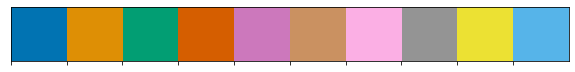

['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161', '#fbafe4', '#949494', '#ece133', '#56b4e9']


In [26]:
# Set Color Palette to be colorblind friendly
current_palette = sns.color_palette('colorblind')
sns.palplot(sns.color_palette("colorblind"))
plt.show()
current_cmap = list((sns.color_palette("colorblind").as_hex()))
print(current_cmap)
current_colormap = ListedColormap(sns.color_palette('colorblind'))

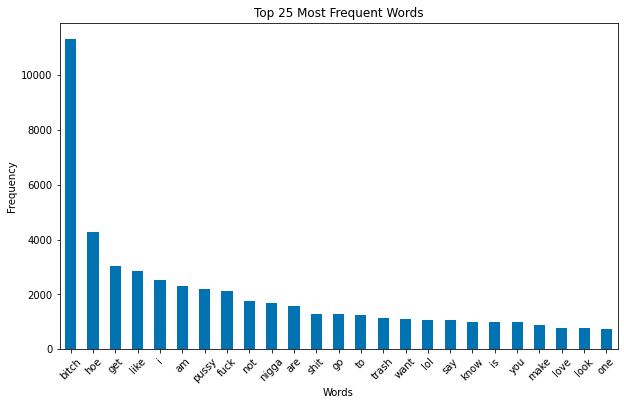

In [27]:
# Get Word Frequencies from Cleaned Tweet and Filter Out Hashtag Symbols
word_frequencies = df1['clean_tweet'].str.split(expand=True).stack().value_counts()

word_frequencies = word_frequencies[~word_frequencies.index.str.startswith('#')]

word_frequencies = word_frequencies.sort_values(ascending=False)

# Plot top 25
top_n = 25
top_words = word_frequencies.head(top_n)

plt.figure(figsize=(10, 6))
top_words.plot(kind='bar', colormap = current_colormap)
plt.title(f'Top {top_n} Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.savefig(eda_path2 + 'word_frequency.png')
plt.show()

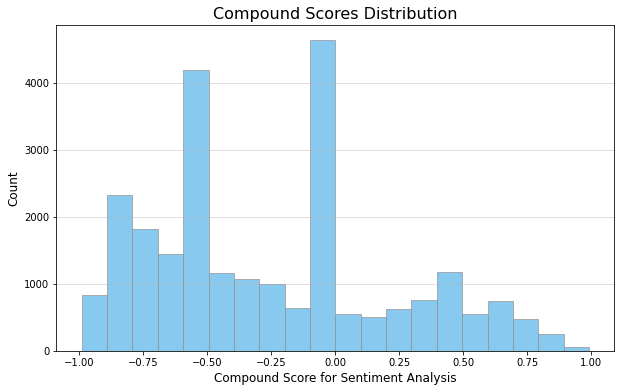

In [28]:
# Histogram for the Compound Score
plt.figure(figsize=(10, 6))
plt.hist(df1['compound_score'], bins=20, edgecolor='#949494', color='#56b4e9', alpha=0.7)
plt.xlabel('Compound Score for Sentiment Analysis',fontsize=12)
plt.ylabel('Count',fontsize=12)
plt.title('Compound Scores Distribution',fontsize=16)
plt.xticks(fontsize=10)
plt.grid(axis='y', alpha=0.5)
plt.savefig(eda_path2 + 'compound_score.png')
plt.show()

In [29]:
# Check for any empty rows after cleaning

df1[df1.isna().any(axis=1)]

,tweet,tokens,clean_tweet,class,tweet_length,sentiment_scores,sentiment,compound_score


In [30]:
df1

,tweet,tokens,clean_tweet,class,tweet_length,sentiment_scores,sentiment,compound_score
0,!!! RT @mayasolovely: As a woman you shouldn't...,"[@mayasolovely, woman, complain, cleaning, hou...",@mayasolovely woman complain cleaning house ...,0,9,"{'neg': 0.238, 'neu': 0.762, 'pos': 0.0, 'comp...",negative,-0.3612
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,"[@mleew, boy, dat, coldtyga, dwn, bad, cuffin,...",@mleew boy dat coldtyga dwn bad cuffin dat h...,1,11,"{'neg': 0.259, 'neu': 0.741, 'pos': 0.0, 'comp...",negative,-0.5423
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,"[@urkindofbrand, dawg, @sbabylife, ever, fuck,...",@urkindofbrand dawg @sbabylife ever fuck bi...,1,10,"{'neg': 0.761, 'neu': 0.239, 'pos': 0.0, 'comp...",negative,-0.9423
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,"[@cganderson, @vivabased, look, like, tranny]",@cganderson @vivabased look like tranny,1,5,"{'neg': 0.0, 'neu': 0.615, 'pos': 0.385, 'comp...",positive,0.3612
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,"[@shenikarobes, shit, hear, might, true, might...",@shenikarobes shit hear might true might fak...,1,10,"{'neg': 0.43, 'neu': 0.407, 'pos': 0.163, 'com...",negative,-0.6808
...,...,...,...,...,...,...,...,...
25291,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,"[yous, muthafin, lie, @lifeasking, @pearls, @c...",yous muthafin lie @lifeasking @pearls @coreyem...,1,13,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,0.0000
25292,"you've gone and broke the wrong heart baby, an...","[go, break, wrong, hea, baby, drive, redneck, ...",go break wrong hea baby drive redneck crazy,1,8,"{'neg': 0.478, 'neu': 0.522, 'pos': 0.0, 'comp...",negative,-0.6705
25294,young buck wanna eat!!.. dat nigguh like I ain...,"[young, buck, want, to, eat, dat, nigguh, like...",young buck want to eat dat nigguh like are not...,1,12,"{'neg': 0.0, 'neu': 0.725, 'pos': 0.275, 'comp...",positive,0.4215
25295,youu got wild bitches tellin you lies,"[youu, get, wild, bitch, tellin, lie]",youu get wild bitch tellin lie,1,6,"{'neg': 0.432, 'neu': 0.568, 'pos': 0.0, 'comp...",negative,-0.5859


Vectorization for Train, Test, Split

For the parameters, the data is split with 85% for training and 15% for test. The sentiment label as 'negative', 'neutral', and 'positive' are assigned numerical values to be prepared for modeling. For the modeling of text-based data, the cleaned tweets are then converted into a matrix of TF-IDF features using Tfidfvectorizer with an n-gram range of 1, 2, and 3 word parts.

In [31]:
# Set the Label to be Numerical
label = df1['sentiment']
sentiment_ordering = ['negative', 'neutral', 'positive']
y = label.apply(lambda x: sentiment_ordering.index(x))

In [32]:
# Splitting of Data

X_train, X_test, y_train, y_test = train_test_split(df1['clean_tweet'], y, test_size = .15, stratify = y, random_state = 1025)

# Use TfidfVectorizer to convert text to a matrix of TF-IDF features
vec = TfidfVectorizer(strip_accents = 'unicode', analyzer = 'word', ngram_range = (1,3))
vec.fit(X_train)
X_train = vec.transform(X_train)
X_test = vec.transform(X_test)

In [33]:
df1.to_csv('../Data/Prepared_Data.csv')

Now Ready for Modeling